## Neighborhood/Global Distances

In [1]:
import sys
sys.path.append('../')
from fcc_DRs import *
%matplotlib inline

FIt-SNE repository not detected. Functionality will be disabled.


In [2]:
# read in Macosko retina data
retina = RNA_counts.from_file('../inputs/GSM1626793_P14Retina_1.processed.norowlabels.tsv.gz', labels=[None,0], barcodefile='pymethods_out/retina_clu.csv')
# read in Herring colon data
colon = RNA_counts.from_file('../inputs/GSM2743164_rep1_colon_rnaseq.processed.norowlabels.tsv.gz', labels=[None,0], barcodefile='pymethods_out/colon_clu.csv')

In [3]:
# look at dimensions of counts matrix (cells, genes)
retina.data.shape

(1326, 500)

In [4]:
# look at dimensions of counts matrix (cells, genes)
colon.data.shape

(1117, 500)

In [5]:
# create dictionaries for dumping results into
final_distance_stats = {'Retina':{'Bipolar - Rods':{}, 'Bipolar - Amacrine':{}, 'Rods - Amacrine':{}}, 'Colon':{'Immature - Mature':{}, 'Immature - Developing':{}, 'Developing - Mature':{}}}

---

In [6]:
def triangulation(pre_obj, post_obj, clusters, cluster_names, figsize=(6,6), pre_transform='arcsinh', legend=True):
    '''
    pre = RNA_counts object
    post = DR object
    clusters = list of barcode IDs i.e. ['0','1','2'] to calculate pairwise distances between clusters 0, 1 and 2
    cluster_names = list of cluster names for labeling i.e. ['Bipolar Cells','Rods','Amacrine Cells'] for clusters 0, 1 and 2, respectively
    '''
    dist_0_1 = pre_obj.barcode_distance_matrix(ranks=[clusters[0],clusters[1]], transform=pre_transform).flatten()
    dist_0_2 = pre_obj.barcode_distance_matrix(ranks=[clusters[0],clusters[2]], transform=pre_transform).flatten()
    dist_1_2 = pre_obj.barcode_distance_matrix(ranks=[clusters[1],clusters[2]], transform=pre_transform).flatten()
    dist = np.append(np.append(dist_0_1,dist_0_2), dist_1_2)
    dist_norm = (dist-dist.min())/(dist.max()-dist.min())
    dist_norm_0_1 = dist_norm[:dist_0_1.shape[0]]
    dist_norm_0_2 = dist_norm[dist_0_1.shape[0]:dist_0_1.shape[0]+dist_0_2.shape[0]]
    dist_norm_1_2 = dist_norm[dist_0_1.shape[0]+dist_0_2.shape[0]:]
    
    post_0_1 = post_obj.barcode_distance_matrix(ranks=[clusters[0],clusters[1]]).flatten()
    post_0_2 = post_obj.barcode_distance_matrix(ranks=[clusters[0],clusters[2]]).flatten()
    post_1_2 = post_obj.barcode_distance_matrix(ranks=[clusters[1],clusters[2]]).flatten()
    post = np.append(np.append(post_0_1,post_0_2), post_1_2)
    post_norm = (post-post.min())/(post.max()-post.min())
    post_norm_0_1 = post_norm[:post_0_1.shape[0]]
    post_norm_0_2 = post_norm[post_0_1.shape[0]:post_0_1.shape[0]+post_0_2.shape[0]]
    post_norm_1_2 = post_norm[post_0_1.shape[0]+post_0_2.shape[0]:]
    
    #corr_stats = [sc.stats.pearsonr(x=dist_0_1, y=post_0_1)[0], sc.stats.pearsonr(x=dist_0_2, y=post_0_2)[0], sc.stats.pearsonr(x=dist_1_2, y=post_1_2)[0]]
    EMD = [sc.stats.wasserstein_distance(dist_norm_0_1, post_norm_0_1), sc.stats.wasserstein_distance(dist_norm_0_2, post_norm_0_2), sc.stats.wasserstein_distance(dist_norm_1_2, post_norm_1_2)]
    
    g = sns.JointGrid(x=dist_norm, y=post_norm, space=0, height=figsize[0])
    g.plot_joint(plt.hist2d, bins=50, cmap=sns.cubehelix_palette(as_cmap=True))
    sns.kdeplot(dist_norm_0_1, shade=False, bw=0.01, ax=g.ax_marg_x,  color=sns.cubehelix_palette()[1], label=cluster_names[0]+' - '+cluster_names[1], legend=legend)
    sns.kdeplot(dist_norm_0_2, shade=False, bw=0.01, ax=g.ax_marg_x,  color=sns.cubehelix_palette()[3], label=cluster_names[0]+' - '+cluster_names[2], legend=legend)
    sns.kdeplot(dist_norm_1_2, shade=False, bw=0.01, ax=g.ax_marg_x,  color=sns.cubehelix_palette()[5], label=cluster_names[1]+' - '+cluster_names[2], legend=legend)
    if legend:
        g.ax_marg_x.legend(loc=(1.01,0.1))
    sns.kdeplot(post_norm_0_1, shade=False, bw=0.01, vertical=True,  color=sns.cubehelix_palette()[1], ax=g.ax_marg_y)
    sns.kdeplot(post_norm_0_2, shade=False, bw=0.01, vertical=True,  color=sns.cubehelix_palette()[3], ax=g.ax_marg_y)
    sns.kdeplot(post_norm_1_2, shade=False, bw=0.01, vertical=True,  color=sns.cubehelix_palette()[5], ax=g.ax_marg_y)
    g.ax_joint.plot(np.linspace(max(min(dist_norm),min(post_norm)),1,100), np.linspace(max(min(dist_norm),min(post_norm)),1,100), linestyle='dashed', color=sns.cubehelix_palette()[-1]) # plot identity line as reference for regression
    plt.xlabel('Pre-Transformation', fontsize=14)
    plt.ylabel('Post-Transformation', fontsize=14)
    plt.tick_params(labelleft=False, labelbottom=False)
    
    return EMD

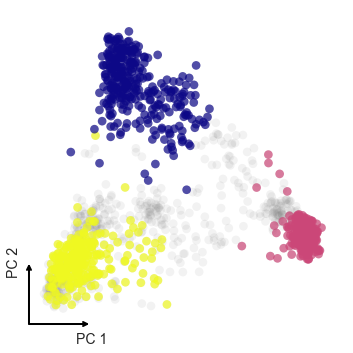

In [7]:
retina_PCA2 = fcc_PCA(matrix=retina.arcsinh_norm(), barcodes=retina.barcodes, n_components=2)
retina_PCA2.plot_barcodes(ranks=['0','1','2']) # bipolar cells, rods, and amacrine cells

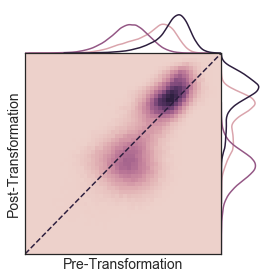

In [8]:
EMD = triangulation(pre_obj=retina, post_obj=retina_PCA2, clusters=['0','1','2'], cluster_names=['Bipolar Cells','Rods','Amacrine Cells'], figsize=(4,4), legend=False)

plt.savefig(fname='../images/retina_neighborhood_PCA2_corr.png', transparent=True, bbox_inches='tight', dpi=1000)
# dump outputs into dictionary
final_distance_stats['Retina']['Bipolar - Rods']['PCA (2)'], final_distance_stats['Retina']['Bipolar - Amacrine']['PCA (2)'], final_distance_stats['Retina']['Rods - Amacrine']['PCA (2)'] = EMD

In [9]:
retina_PCA10 = fcc_PCA(matrix=retina.arcsinh_norm(), barcodes=retina.barcodes, n_components=10)

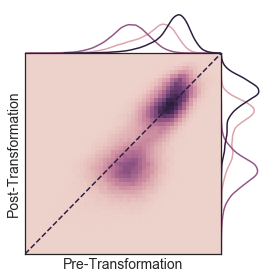

In [10]:
EMD = triangulation(pre_obj=retina, post_obj=retina_PCA10, clusters=['0','1','2'], cluster_names=['Bipolar Cells','Rods','Amacrine Cells'], figsize=(4,4), legend=False)

plt.savefig(fname='../images/retina_neighborhood_PCA10_corr.png', transparent=True, bbox_inches='tight', dpi=1000)
# dump outputs into dictionary
final_distance_stats['Retina']['Bipolar - Rods']['PCA (10)'], final_distance_stats['Retina']['Bipolar - Amacrine']['PCA (10)'], final_distance_stats['Retina']['Rods - Amacrine']['PCA (10)'] = EMD

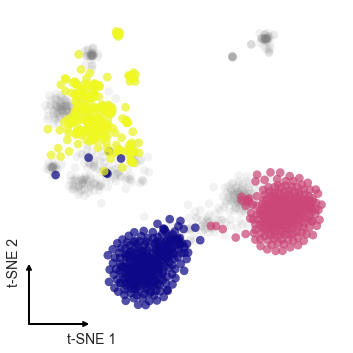

In [11]:
retina_tSNE = DR.from_file('pymethods_out/retina_tSNE.csv', name='t-SNE', labels=[None,None], barcodefile='pymethods_out/retina_clu.csv')
retina_tSNE.plot_barcodes(ranks=['0','1','2']) 

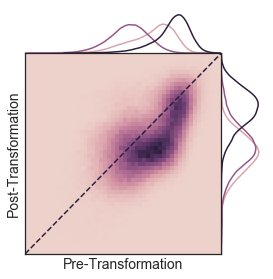

In [12]:
EMD = triangulation(pre_obj=retina, post_obj=retina_tSNE, clusters=['0','1','2'], cluster_names=['Bipolar Cells','Rods','Amacrine Cells'], figsize=(4,4), legend=False)

plt.savefig(fname='../images/retina_neighborhood_tSNE_corr.png', transparent=True, bbox_inches='tight', dpi=1000)
# dump outputs into dictionary
final_distance_stats['Retina']['Bipolar - Rods']['t-SNE'], final_distance_stats['Retina']['Bipolar - Amacrine']['t-SNE'], final_distance_stats['Retina']['Rods - Amacrine']['t-SNE'] = EMD

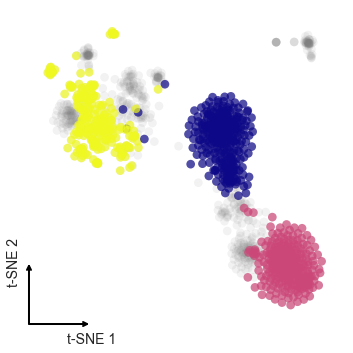

In [13]:
retina_FItSNE = DR.from_file('pymethods_out/retina_FItSNE.csv', name='t-SNE', labels=[None,None], barcodefile='pymethods_out/retina_clu.csv')
retina_FItSNE.plot_barcodes(ranks=['0','1','2']) 

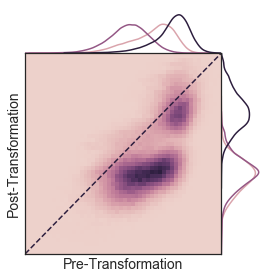

In [14]:
EMD = triangulation(pre_obj=retina, post_obj=retina_FItSNE, clusters=['0','1','2'], cluster_names=['Bipolar Cells','Rods','Amacrine Cells'], figsize=(4,4), legend=False)

plt.savefig(fname='../images/retina_neighborhood_FItSNE_corr.png', transparent=True, bbox_inches='tight', dpi=1000)
# dump outputs into dictionary
final_distance_stats['Retina']['Bipolar - Rods']['FIt-SNE'], final_distance_stats['Retina']['Bipolar - Amacrine']['FIt-SNE'], final_distance_stats['Retina']['Rods - Amacrine']['FIt-SNE'] = EMD

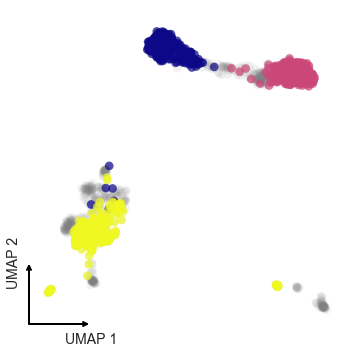

In [15]:
retina_UMAP = DR.from_file('pymethods_out/retina_UMAP.csv', name='UMAP', labels=[None,None], barcodefile='pymethods_out/retina_clu.csv')
retina_UMAP.plot_barcodes(ranks=['0','1','2']) 

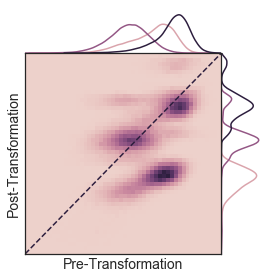

In [16]:
EMD = triangulation(pre_obj=retina, post_obj=retina_UMAP, clusters=['0','1','2'], cluster_names=['Bipolar Cells','Rods','Amacrine Cells'], figsize=(4,4), legend=False)

plt.savefig(fname='../images/retina_neighborhood_UMAP_corr.png', transparent=True, bbox_inches='tight', dpi=1000)
# dump outputs into dictionary
final_distance_stats['Retina']['Bipolar - Rods']['UMAP'], final_distance_stats['Retina']['Bipolar - Amacrine']['UMAP'], final_distance_stats['Retina']['Rods - Amacrine']['UMAP'] = EMD

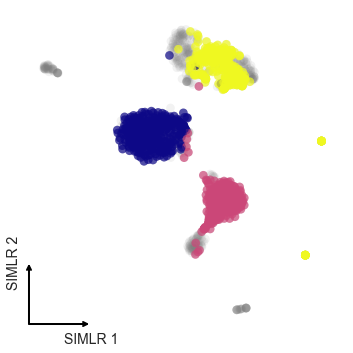

In [17]:
retina_SIMLR = DR.from_file('Rmethods_out/retina_SIMLR_F.csv', name='SIMLR', labels=[None,0], barcodefile='pymethods_out/retina_clu.csv')
retina_SIMLR.plot_barcodes(ranks=['0','1','2'])

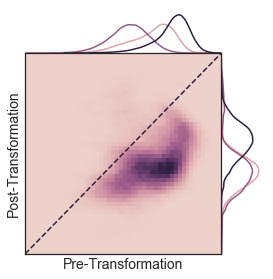

In [18]:
EMD = triangulation(pre_obj=retina, post_obj=retina_SIMLR, clusters=['0','1','2'], cluster_names=['Bipolar Cells','Rods','Amacrine Cells'], figsize=(4,4), legend=False)

plt.savefig(fname='../images/retina_neighborhood_SIMLR_corr.png', transparent=True, bbox_inches='tight', dpi=1000)
# dump outputs into dictionary
final_distance_stats['Retina']['Bipolar - Rods']['SIMLR'], final_distance_stats['Retina']['Bipolar - Amacrine']['SIMLR'], final_distance_stats['Retina']['Rods - Amacrine']['SIMLR'] = EMD

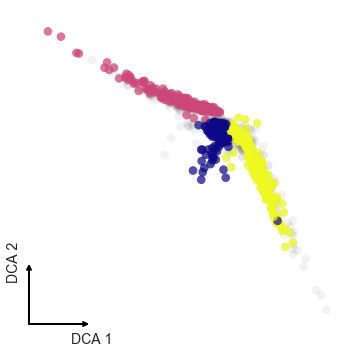

In [19]:
retina_DCA = DR.from_file('pymethods_out/retina_DCA.csv', name='DCA', labels=[None,None], barcodefile='pymethods_out/retina_clu.csv')
retina_DCA.plot_barcodes(ranks=['0','1','2']) # rods & cones

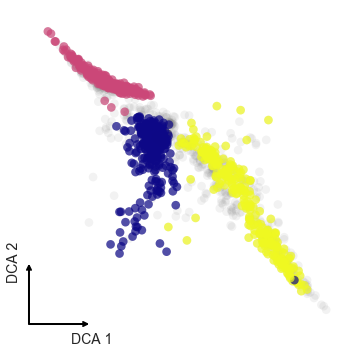

In [20]:
retina_DCA = DR(latent=retina_DCA.arcsinh_norm(norm=None, scale=1), name='DCA', barcodes=retina_DCA.barcodes)
retina_DCA.plot_barcodes(ranks=['0','1','2']) # rods & cones

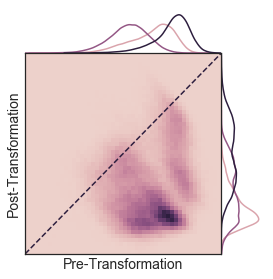

In [21]:
EMD = triangulation(pre_obj=retina, post_obj=retina_DCA, clusters=['0','1','2'], cluster_names=['Bipolar Cells','Rods','Amacrine Cells'], figsize=(4,4), legend=False, pre_transform='arcsinh')

plt.savefig(fname='../images/retina_neighborhood_DCA_corr.png', transparent=True, bbox_inches='tight', dpi=1000)
# dump outputs into dictionary
final_distance_stats['Retina']['Bipolar - Rods']['DCA'], final_distance_stats['Retina']['Bipolar - Amacrine']['DCA'], final_distance_stats['Retina']['Rods - Amacrine']['DCA'] = EMD

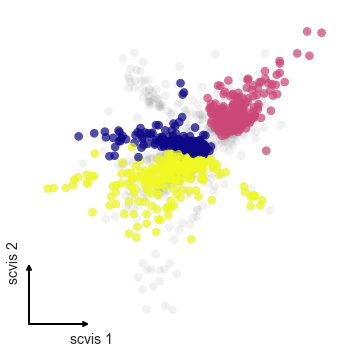

In [22]:
retina_scvis = DR.from_file('scvis_out/retina/perplexity_30_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.tsv', name='scvis', labels=[0,0], barcodefile='pymethods_out/retina_clu.csv')
retina_scvis.plot_barcodes(ranks=['0','1','2']) # rods & cones

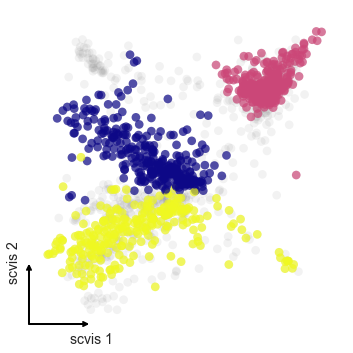

In [23]:
retina_scvis = DR(latent=retina_scvis.arcsinh_norm(norm=None, scale=1), name='scvis', barcodes=retina_scvis.barcodes)
retina_scvis.plot_barcodes(ranks=['0','1','2']) # rods & cones

In [24]:
retina_scvis.plot_barcodes(ranks=['0','1','2'], figsize=(4,4), save_to='../images/retina_neighborhood_scvis.png') # rods & cones

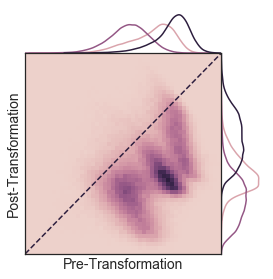

In [25]:
EMD = triangulation(pre_obj=retina, post_obj=retina_scvis, clusters=['0','1','2'], cluster_names=['Bipolar Cells','Rods','Amacrine Cells'], figsize=(4,4), legend=False, pre_transform='arcsinh')

plt.savefig(fname='../images/retina_neighborhood_scvis_corr.png', transparent=True, bbox_inches='tight', dpi=1000)
# dump outputs into dictionary
final_distance_stats['Retina']['Bipolar - Rods']['scvis'], final_distance_stats['Retina']['Bipolar - Amacrine']['scvis'], final_distance_stats['Retina']['Rods - Amacrine']['scvis'] = EMD

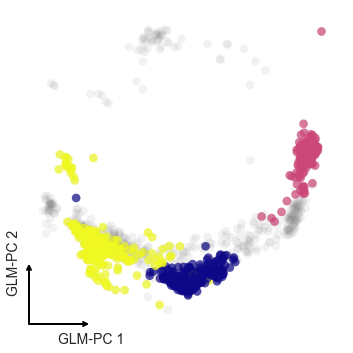

In [26]:
retina_GLMPCA = DR.from_file('Rmethods_out/retina_GLM-PCA.csv', name='GLM-PC', labels=[None,0], barcodefile='pymethods_out/retina_clu.csv')
retina_GLMPCA.plot_barcodes(ranks=['0','1','2']) 

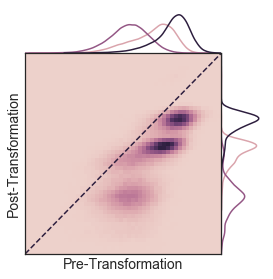

In [27]:
EMD = triangulation(pre_obj=retina, post_obj=retina_GLMPCA, clusters=['0','1','2'], cluster_names=['Bipolar Cells','Rods','Amacrine Cells'], figsize=(4,4), legend=False, pre_transform='arcsinh')

plt.savefig(fname='../images/retina_neighborhood_GLMPCA_corr.png', transparent=True, bbox_inches='tight', dpi=1000)
# dump outputs into dictionary
final_distance_stats['Retina']['Bipolar - Rods']['GLM-PCA'], final_distance_stats['Retina']['Bipolar - Amacrine']['GLM-PCA'], final_distance_stats['Retina']['Rods - Amacrine']['GLM-PCA'] = EMD

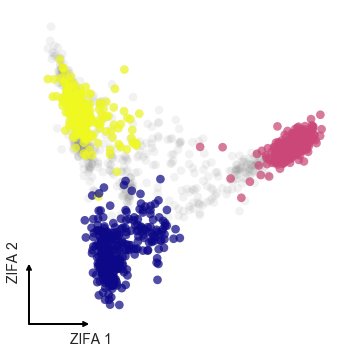

In [28]:
retina_ZIFA = DR.from_file('pymethods_out/retina_ZIFA.csv', name='ZIFA', labels=[None,None], barcodefile='pymethods_out/retina_clu.csv')
retina_ZIFA.plot_barcodes(ranks=['0','1','2']) # rods & cones

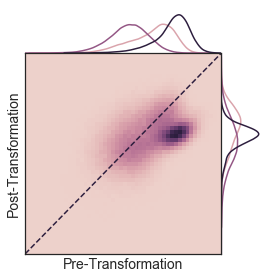

In [29]:
EMD = triangulation(pre_obj=retina, post_obj=retina_ZIFA, clusters=['0','1','2'], cluster_names=['Bipolar Cells','Rods','Amacrine Cells'], figsize=(4,4), legend=False, pre_transform='arcsinh')

plt.savefig(fname='../images/retina_neighborhood_ZIFA_corr.png', transparent=True, bbox_inches='tight', dpi=1000)
# dump outputs into dictionary
final_distance_stats['Retina']['Bipolar - Rods']['ZIFA'], final_distance_stats['Retina']['Bipolar - Amacrine']['ZIFA'], final_distance_stats['Retina']['Rods - Amacrine']['ZIFA'] = EMD

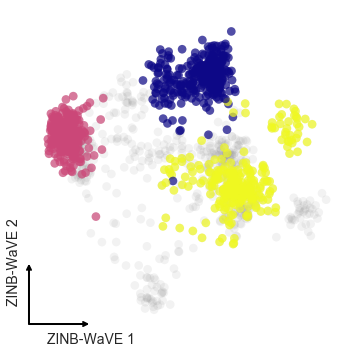

In [30]:
retina_ZINBWAVE = DR.from_file('Rmethods_out/retina_ZINB-WAVE.csv', name='ZINB-WaVE', labels=[None,0], barcodefile='pymethods_out/retina_clu.csv')
retina_ZINBWAVE.plot_barcodes(ranks=['0','1','2']) 

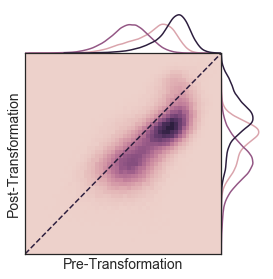

In [31]:
EMD = triangulation(pre_obj=retina, post_obj=retina_ZINBWAVE, clusters=['0','1','2'], cluster_names=['Bipolar Cells','Rods','Amacrine Cells'], figsize=(4,4), legend=False, pre_transform='arcsinh')

plt.savefig(fname='../images/retina_neighborhood_ZINBWAVE_corr.png', transparent=True, bbox_inches='tight', dpi=1000)
# dump outputs into dictionary
final_distance_stats['Retina']['Bipolar - Rods']['ZINB-WaVE'], final_distance_stats['Retina']['Bipolar - Amacrine']['ZINB-WaVE'], final_distance_stats['Retina']['Rods - Amacrine']['ZINB-WaVE'] = EMD

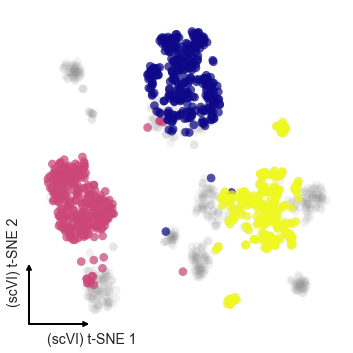

In [32]:
retina_scVI = DR.from_file('pymethods_out/retina_scVI.csv', name='scVI', labels=[None,None], barcodefile='pymethods_out/retina_clu.csv')
retina_scVI_tSNE = DR.from_file('pymethods_out/retina_scVI_tSNE.csv', name='(scVI) t-SNE', labels=[None,None], barcodefile='pymethods_out/retina_clu.csv')
retina_scVI_tSNE.plot_barcodes(ranks=['0','1','2'])

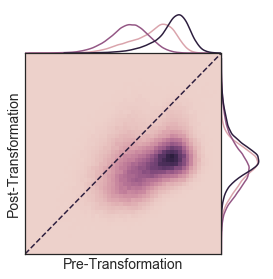

In [33]:
EMD = triangulation(pre_obj=retina, post_obj=retina_scVI, clusters=['0','1','2'], cluster_names=['Bipolar Cells','Rods','Amacrine Cells'], figsize=(4,4), legend=False, pre_transform='arcsinh')

plt.savefig(fname='../images/retina_neighborhood_scVI_corr.png', transparent=True, bbox_inches='tight', dpi=1000)
# dump outputs into dictionary
final_distance_stats['Retina']['Bipolar - Rods']['scVI'], final_distance_stats['Retina']['Bipolar - Amacrine']['scVI'], final_distance_stats['Retina']['Rods - Amacrine']['scVI'] = EMD

---
Now Colon Dataset

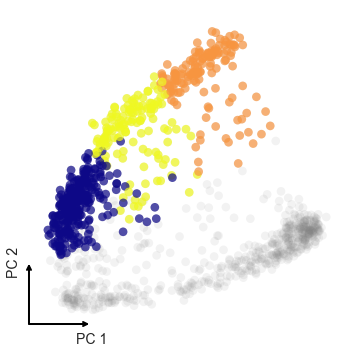

In [34]:
colon_PCA2 = fcc_PCA(matrix=colon.arcsinh_norm(), barcodes=colon.barcodes, n_components=2)
colon_PCA2.plot_barcodes(ranks=['0','3','4']) # mature and developing goblet cells

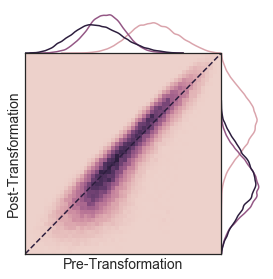

In [35]:
EMD = triangulation(pre_obj=colon, post_obj=colon_PCA2, clusters=['0','3','4'], cluster_names=['Immature Goblet Cells','Mature Goblet Cells','Developing Goblet Cells'], figsize=(4,4), legend=False, pre_transform='arcsinh')

plt.savefig(fname='../images/colon_neighborhood_PCA2_corr.png', transparent=True, bbox_inches='tight', dpi=1000)
# dump outputs into dictionary
final_distance_stats['Colon']['Immature - Mature']['PCA (2)'], final_distance_stats['Colon']['Immature - Developing']['PCA (2)'], final_distance_stats['Colon']['Developing - Mature']['PCA (2)'] = EMD

In [36]:
colon_PCA10 = fcc_PCA(matrix=colon.arcsinh_norm(), barcodes=colon.barcodes, n_components=10)

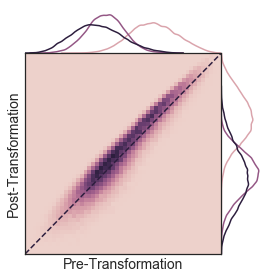

In [37]:
EMD = triangulation(pre_obj=colon, post_obj=colon_PCA10, clusters=['0','3','4'], cluster_names=['Immature Goblet Cells','Mature Goblet Cells','Developing Goblet Cells'], figsize=(4,4), legend=False, pre_transform='arcsinh')

plt.savefig(fname='../images/colon_neighborhood_PCA10_corr.png', transparent=True, bbox_inches='tight', dpi=1000)
# dump outputs into dictionary
final_distance_stats['Colon']['Immature - Mature']['PCA (10)'], final_distance_stats['Colon']['Immature - Developing']['PCA (10)'], final_distance_stats['Colon']['Developing - Mature']['PCA (10)'] = EMD

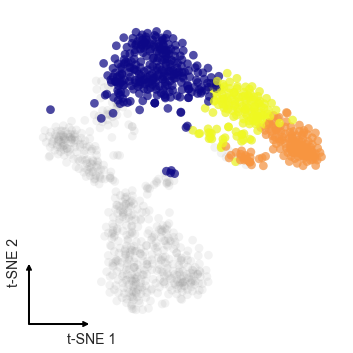

In [38]:
colon_tSNE = DR.from_file('pymethods_out/colon_tSNE.csv', name='t-SNE', labels=[None,None], barcodefile='pymethods_out/colon_clu.csv')
colon_tSNE.plot_barcodes(ranks=['0','3','4']) 

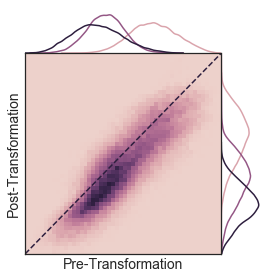

In [39]:
EMD = triangulation(pre_obj=colon, post_obj=colon_tSNE, clusters=['0','3','4'], cluster_names=['Immature Goblet Cells','Mature Goblet Cells','Developing Goblet Cells'], figsize=(4,4), legend=False, pre_transform='arcsinh')

plt.savefig(fname='../images/colon_neighborhood_tSNE_corr.png', transparent=True, bbox_inches='tight', dpi=1000)
# dump outputs into dictionary
final_distance_stats['Colon']['Immature - Mature']['t-SNE'], final_distance_stats['Colon']['Immature - Developing']['t-SNE'], final_distance_stats['Colon']['Developing - Mature']['t-SNE'] = EMD

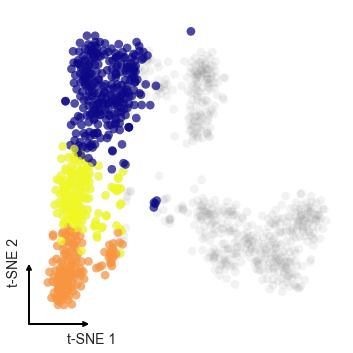

In [40]:
colon_FItSNE = DR.from_file('pymethods_out/colon_FItSNE.csv', name='t-SNE', labels=[None,None], barcodefile='pymethods_out/colon_clu.csv')
colon_FItSNE.plot_barcodes(ranks=['0','3','4']) 

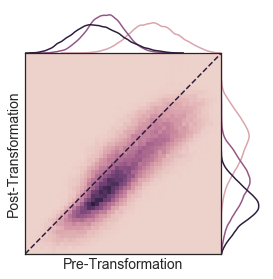

In [41]:
EMD = triangulation(pre_obj=colon, post_obj=colon_FItSNE, clusters=['0','3','4'], cluster_names=['Immature Goblet Cells','Mature Goblet Cells','Developing Goblet Cells'], figsize=(4,4), legend=False, pre_transform='arcsinh')

plt.savefig(fname='../images/colon_neighborhood_FItSNE_corr.png', transparent=True, bbox_inches='tight', dpi=1000)
# dump outputs into dictionary
final_distance_stats['Colon']['Immature - Mature']['FIt-SNE'], final_distance_stats['Colon']['Immature - Developing']['FIt-SNE'], final_distance_stats['Colon']['Developing - Mature']['FIt-SNE'] = EMD

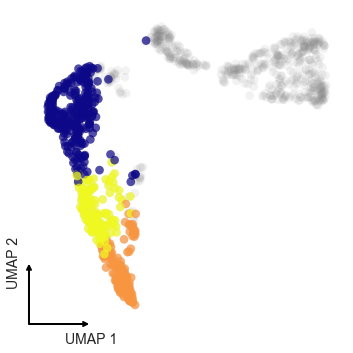

In [42]:
colon_UMAP = DR.from_file('pymethods_out/colon_UMAP.csv', name='UMAP', labels=[None,None], barcodefile='pymethods_out/colon_clu.csv')
colon_UMAP.plot_barcodes(ranks=['0','3','4']) 

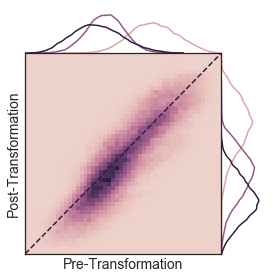

In [43]:
EMD = triangulation(pre_obj=colon, post_obj=colon_UMAP, clusters=['0','3','4'], cluster_names=['Immature Goblet Cells','Mature Goblet Cells','Developing Goblet Cells'], figsize=(4,4), legend=False, pre_transform='arcsinh')

plt.savefig(fname='../images/colon_neighborhood_UMAP_corr.png', transparent=True, bbox_inches='tight', dpi=1000)
# dump outputs into dictionary
final_distance_stats['Colon']['Immature - Mature']['UMAP'], final_distance_stats['Colon']['Immature - Developing']['UMAP'], final_distance_stats['Colon']['Developing - Mature']['UMAP'] = EMD

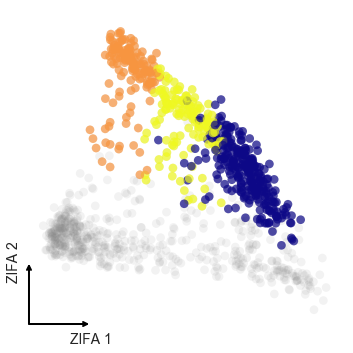

In [44]:
colon_ZIFA = DR.from_file('pymethods_out/colon_ZIFA.csv', name='ZIFA', labels=[None,None], barcodefile='pymethods_out/colon_clu.csv')
colon_ZIFA.plot_barcodes(ranks=['0','3','4'])

In [45]:
colon_ZIFA.plot_barcodes(ranks=['0','3','4'], figsize=(4,4), save_to='../images/colon_neighborhood_ZIFA.png')

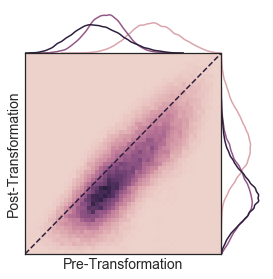

In [46]:
EMD = triangulation(pre_obj=colon, post_obj=colon_ZIFA, clusters=['0','3','4'], cluster_names=['Immature Goblet Cells','Mature Goblet Cells','Developing Goblet Cells'], figsize=(4,4), legend=False, pre_transform='arcsinh')

plt.savefig(fname='../images/colon_neighborhood_ZIFA_corr.png', transparent=True, bbox_inches='tight', dpi=1000)
# dump outputs into dictionary
final_distance_stats['Colon']['Immature - Mature']['ZIFA'], final_distance_stats['Colon']['Immature - Developing']['ZIFA'], final_distance_stats['Colon']['Developing - Mature']['ZIFA'] = EMD

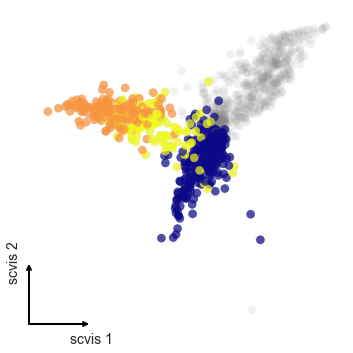

In [47]:
colon_scvis = DR.from_file('scvis_out/colon/perplexity_30_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.tsv', name='scvis', labels=[0,0], barcodefile='pymethods_out/colon_clu.csv')
colon_scvis.plot_barcodes(ranks=['0','3','4'])

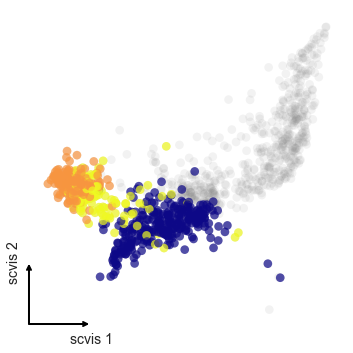

In [48]:
colon_scvis = DR(latent=colon_scvis.arcsinh_norm(norm=None, scale=1), name='scvis', barcodes=colon_scvis.barcodes)
colon_scvis.plot_barcodes(ranks=['0','3','4']) 

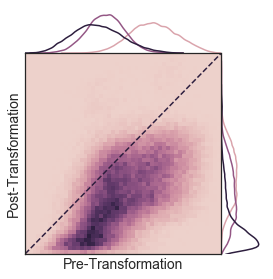

In [49]:
EMD = triangulation(pre_obj=colon, post_obj=colon_scvis, clusters=['0','3','4'], cluster_names=['Immature Goblet Cells','Mature Goblet Cells','Developing Goblet Cells'], figsize=(4,4), legend=False, pre_transform='arcsinh')

plt.savefig(fname='../images/colon_neighborhood_scvis_corr.png', transparent=True, bbox_inches='tight', dpi=1000)
# dump outputs into dictionary
final_distance_stats['Colon']['Immature - Mature']['scvis'], final_distance_stats['Colon']['Immature - Developing']['scvis'], final_distance_stats['Colon']['Developing - Mature']['scvis'] = EMD

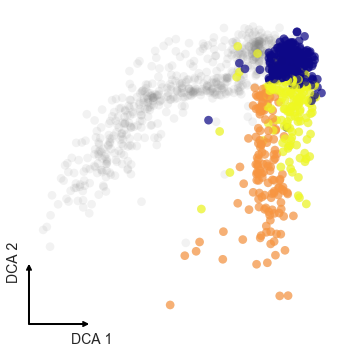

In [50]:
colon_DCA = DR.from_file('pymethods_out/colon_DCA.csv', name='DCA', labels=[None,None], barcodefile='pymethods_out/colon_clu.csv')
colon_DCA.plot_barcodes(ranks=['0','3','4'])

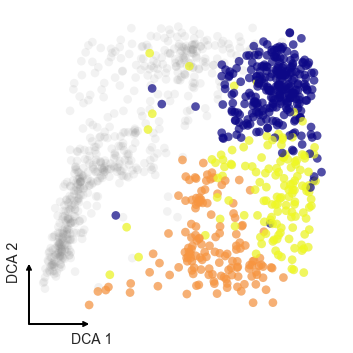

In [51]:
colon_DCA = DR(latent=colon_DCA.arcsinh_norm(norm=None, scale=1), name='DCA', barcodes=colon_DCA.barcodes)
colon_DCA.plot_barcodes(ranks=['0','3','4']) 

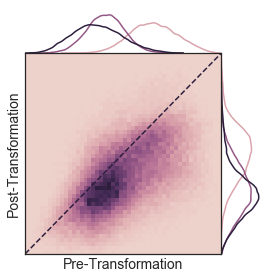

In [52]:
EMD = triangulation(pre_obj=colon, post_obj=colon_DCA, clusters=['0','3','4'], cluster_names=['Immature Goblet Cells','Mature Goblet Cells','Developing Goblet Cells'], figsize=(4,4), legend=False, pre_transform='arcsinh')

plt.savefig(fname='../images/colon_neighborhood_DCA_corr.png', transparent=True, bbox_inches='tight', dpi=1000)
# dump outputs into dictionary
final_distance_stats['Colon']['Immature - Mature']['DCA'], final_distance_stats['Colon']['Immature - Developing']['DCA'], final_distance_stats['Colon']['Developing - Mature']['DCA'] = EMD

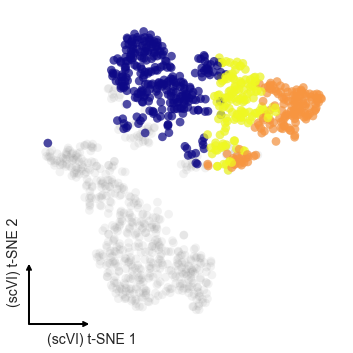

In [53]:
colon_scVI = DR.from_file('pymethods_out/colon_scVI.csv', name='scVI', labels=[None,None], barcodefile='pymethods_out/colon_clu.csv')
colon_scVI_tSNE = DR.from_file('pymethods_out/colon_scVI_tSNE.csv', name='(scVI) t-SNE', labels=[None,None], barcodefile='pymethods_out/colon_clu.csv')
colon_scVI_tSNE.plot_barcodes(ranks=['0','3','4'])

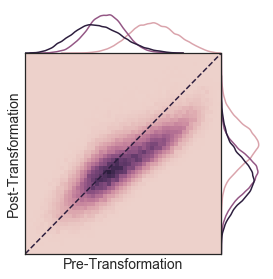

In [54]:
EMD = triangulation(pre_obj=colon, post_obj=colon_scVI, clusters=['0','3','4'], cluster_names=['Immature Goblet Cells','Mature Goblet Cells','Developing Goblet Cells'], figsize=(4,4), legend=False, pre_transform='arcsinh')

plt.savefig(fname='../images/colon_neighborhood_scVI_corr.png', transparent=True, bbox_inches='tight', dpi=1000)
# dump outputs into dictionary
final_distance_stats['Colon']['Immature - Mature']['scVI'], final_distance_stats['Colon']['Immature - Developing']['scVI'], final_distance_stats['Colon']['Developing - Mature']['scVI'] = EMD

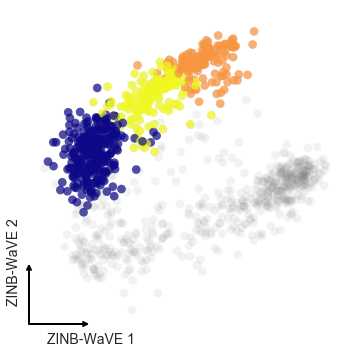

In [55]:
colon_ZINBWAVE = DR.from_file('Rmethods_out/colon_ZINB-WAVE.csv', name='ZINB-WaVE', labels=[None,0], barcodefile='pymethods_out/colon_clu.csv')
colon_ZINBWAVE.plot_barcodes(ranks=['0','3','4']) 

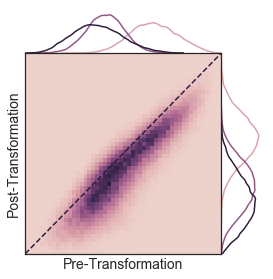

In [56]:
EMD = triangulation(pre_obj=colon, post_obj=colon_ZINBWAVE, clusters=['0','3','4'], cluster_names=['Immature Goblet Cells','Mature Goblet Cells','Developing Goblet Cells'], figsize=(4,4), legend=False, pre_transform='arcsinh')

plt.savefig(fname='../images/colon_neighborhood_ZINBWAVE_corr.png', transparent=True, bbox_inches='tight', dpi=1000)
# dump outputs into dictionary
final_distance_stats['Colon']['Immature - Mature']['ZINB-WaVE'], final_distance_stats['Colon']['Immature - Developing']['ZINB-WaVE'], final_distance_stats['Colon']['Developing - Mature']['ZINB-WaVE'] = EMD

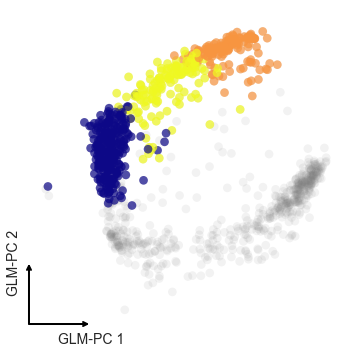

In [57]:
colon_GLMPCA = DR.from_file('Rmethods_out/colon_GLM-PCA.csv', name='GLM-PC', labels=[None,0], barcodefile='pymethods_out/colon_clu.csv')
colon_GLMPCA.plot_barcodes(ranks=['0','3','4']) 

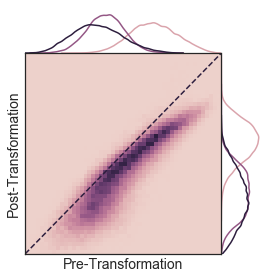

In [58]:
EMD = triangulation(pre_obj=colon, post_obj=colon_GLMPCA, clusters=['0','3','4'], cluster_names=['Immature Goblet Cells','Mature Goblet Cells','Developing Goblet Cells'], figsize=(4,4), legend=False, pre_transform='arcsinh')

plt.savefig(fname='../images/colon_neighborhood_GLMPCA_corr.png', transparent=True, bbox_inches='tight', dpi=1000)
# dump outputs into dictionary
final_distance_stats['Colon']['Immature - Mature']['GLM-PCA'], final_distance_stats['Colon']['Immature - Developing']['GLM-PCA'], final_distance_stats['Colon']['Developing - Mature']['GLM-PCA'] = EMD

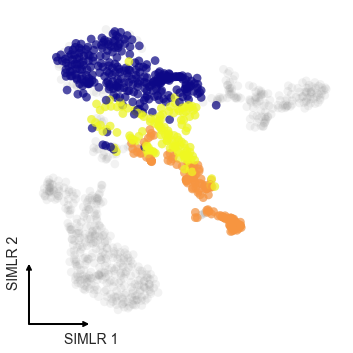

In [59]:
colon_SIMLR = DR.from_file('Rmethods_out/colon_SIMLR_F.csv', name='SIMLR', labels=[None,0], barcodefile='pymethods_out/colon_clu.csv')
colon_SIMLR.plot_barcodes(ranks=['0','3','4'])

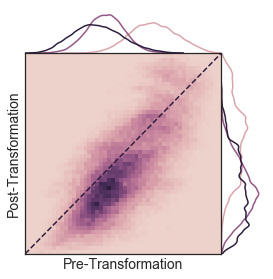

In [60]:
EMD = triangulation(pre_obj=colon, post_obj=colon_SIMLR, clusters=['0','3','4'], cluster_names=['Immature Goblet Cells','Mature Goblet Cells','Developing Goblet Cells'], figsize=(4,4), legend=False, pre_transform='arcsinh')

plt.savefig(fname='../images/colon_neighborhood_SIMLR_corr.png', transparent=True, bbox_inches='tight', dpi=1000)
# dump outputs into dictionary
final_distance_stats['Colon']['Immature - Mature']['SIMLR'], final_distance_stats['Colon']['Immature - Developing']['SIMLR'], final_distance_stats['Colon']['Developing - Mature']['SIMLR'] = EMD

---
### Summary Metrics

In [61]:
retina_sum = pd.DataFrame(final_distance_stats['Retina'])
retina_sum['Sum'] = retina_sum.sum(axis=1)
retina_sum = retina_sum.sort_values(by='Sum', ascending=False)
retina_sum.to_csv('retina_neighborhood_metrics.csv')

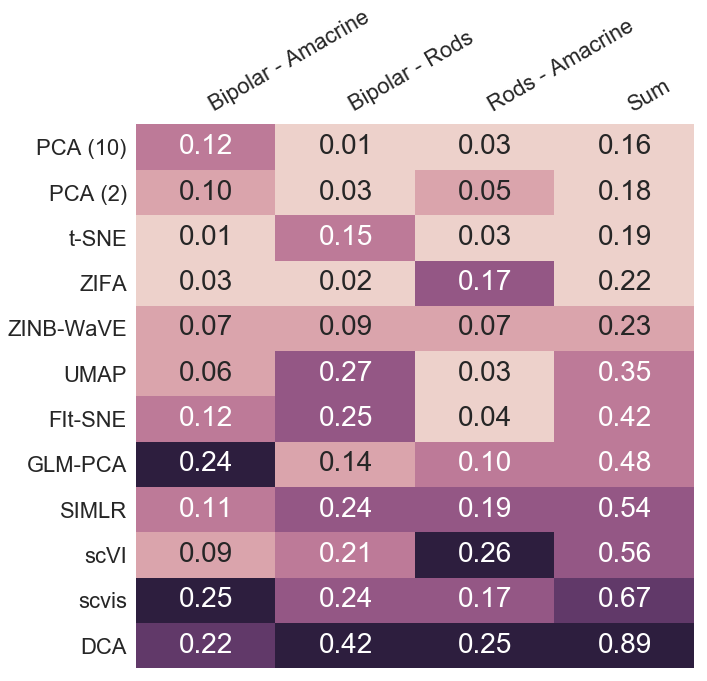

In [62]:
retina_norm=(retina_sum-retina_sum.mean())/retina_sum.std()
sns.set(font_scale=2)
plt.figure(figsize=(10,10))
ax = sns.heatmap(retina_norm, annot=retina_sum, cmap=sns.cubehelix_palette(), robust=True, annot_kws={"size": 28}, fmt='.2f', cbar=False)
ax.invert_yaxis()
ax.xaxis.tick_top()
plt.xticks(rotation=30, ha='left')
ax.tick_params(top=False)
plt.savefig(fname='../images/retina_neighborhood_metrics.png', transparent=True, bbox_inches='tight')

In [63]:
colon_sum = pd.DataFrame(final_distance_stats['Colon'])
colon_sum = colon_sum.reindex(['Immature - Developing','Developing - Mature','Immature - Mature'], axis=1)
colon_sum['Sum'] = colon_sum.sum(axis=1)
colon_sum = colon_sum.sort_values(by='Sum', ascending=False)
colon_sum.to_csv('colon_neighborhood_metrics.csv')

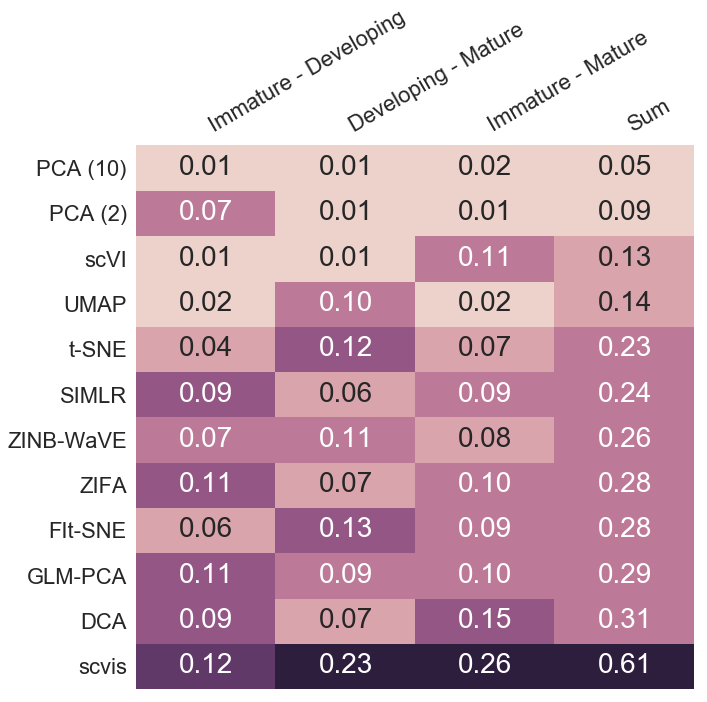

In [64]:
colon_norm=(colon_sum-colon_sum.mean())/colon_sum.std()
sns.set(font_scale=2)
plt.figure(figsize=(10,10))
ax = sns.heatmap(colon_norm, annot=colon_sum, cmap=sns.cubehelix_palette(), robust=True, annot_kws={"size": 28}, fmt='.2f', cbar=False)
ax.invert_yaxis()
ax.xaxis.tick_top()
plt.xticks(rotation=30, ha='left')
ax.tick_params(top=False)
plt.savefig(fname='../images/colon_neighborhood_metrics.png', transparent=True, bbox_inches='tight')